In [36]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Core Libraries
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

# TensorFlow / Keras Modules
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Misc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
from collections import Counter

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
images_directory = '/content/drive/My Drive/images_2000/'
captions_path = '/content/drive/My Drive/captions.txt'

def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

captions = load_captions(captions_path)
captions[:5]


['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n']

In [38]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text.lower()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
captions_IDs = [
    captions[i].split(',')[0] + '\t' + 'start ' + cleaned_captions[i] + ' end\n'
    for i in range(len(cleaned_captions))
]


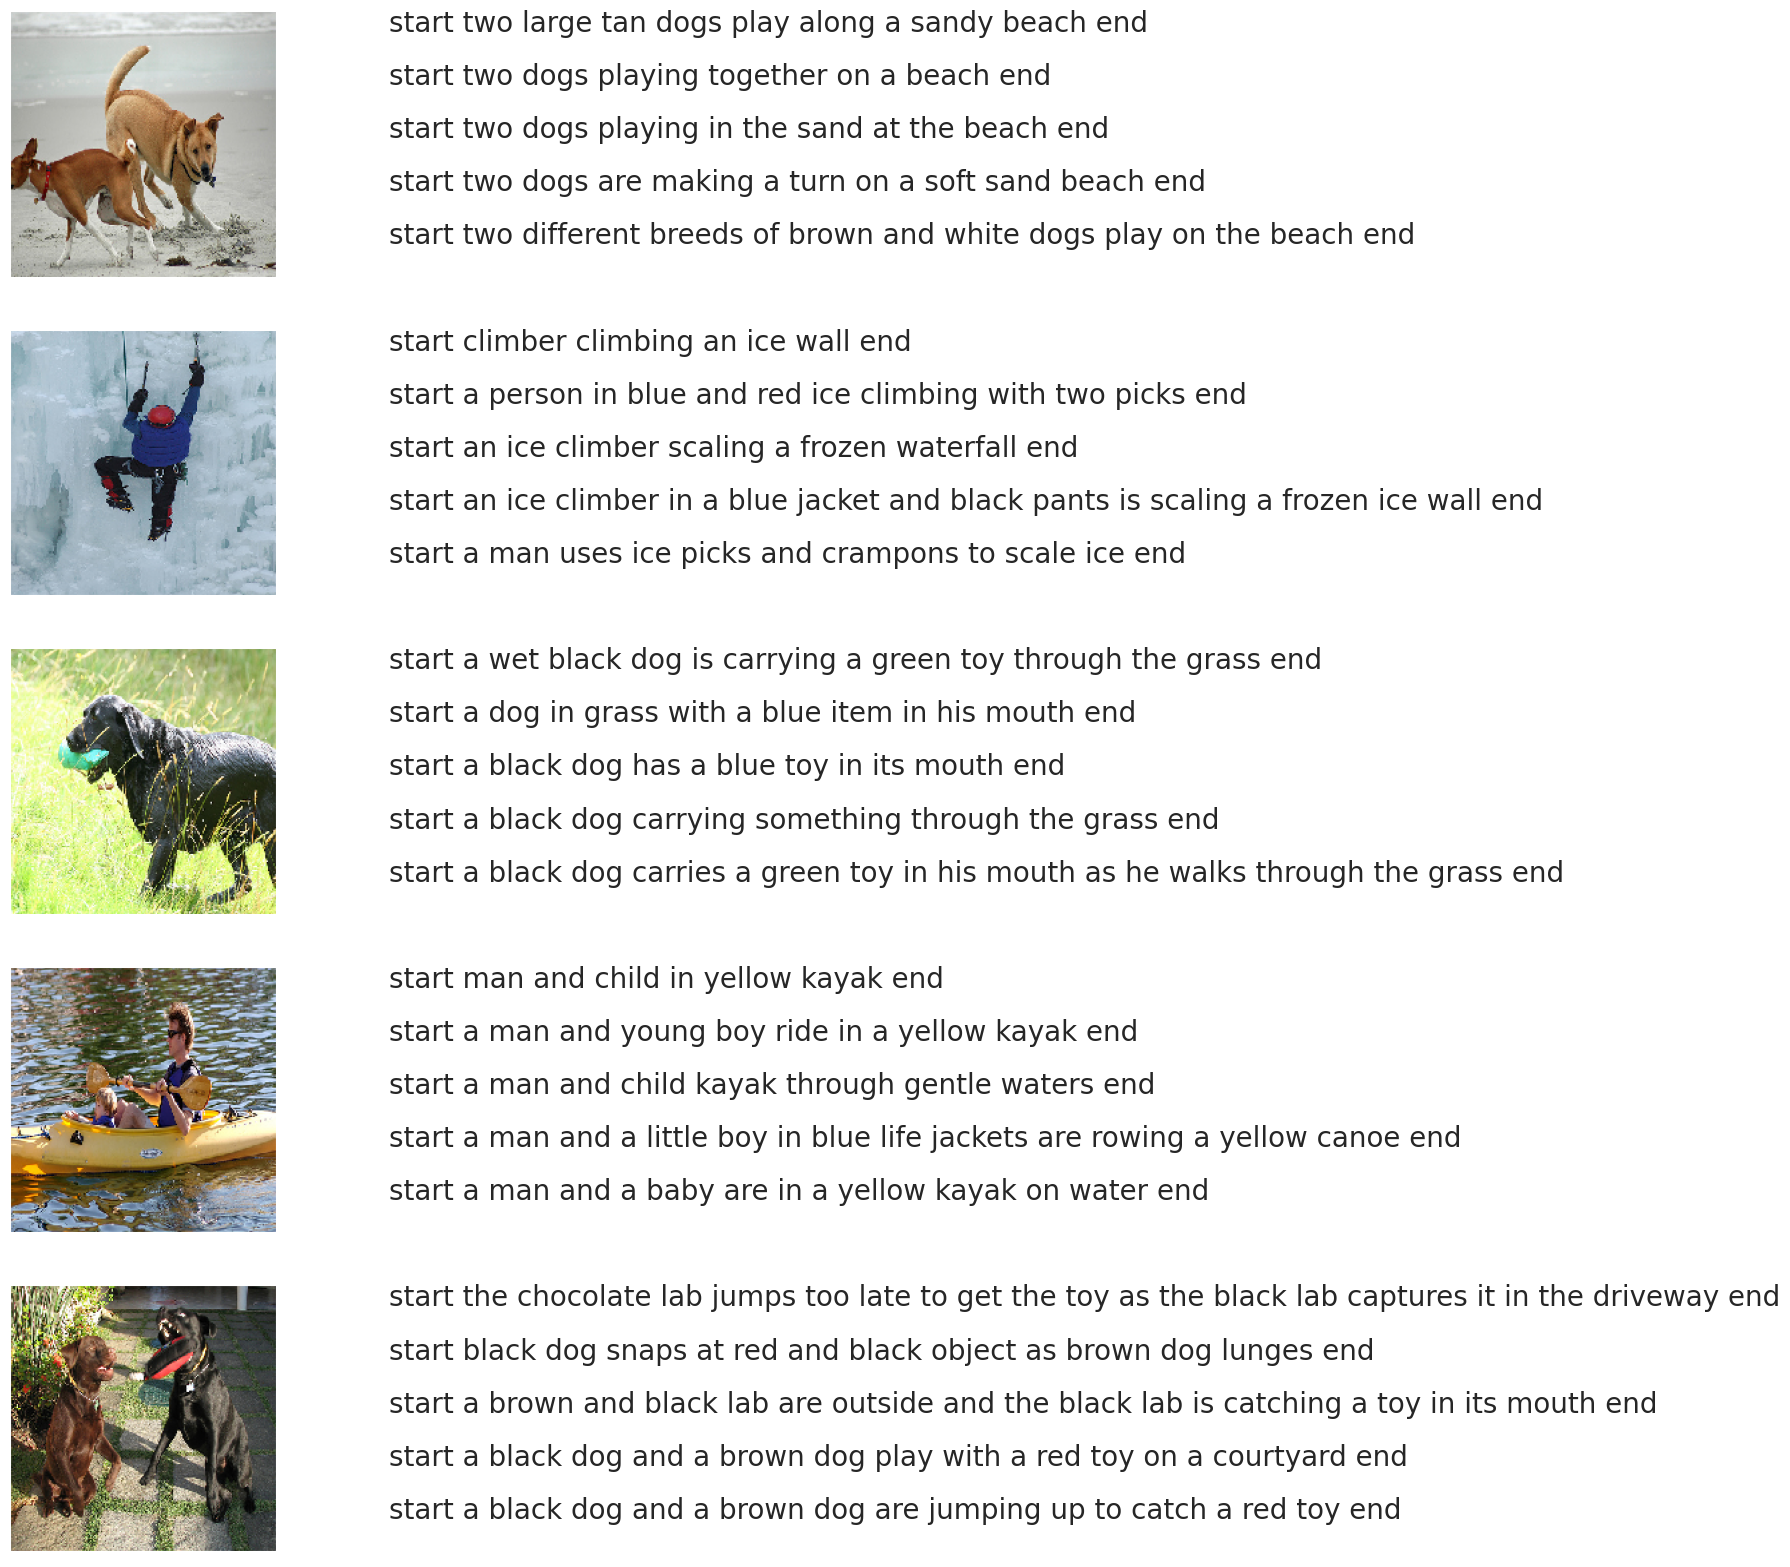

In [39]:
def visualization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)

    list_captions = [x for x in captions_dictionary.items()]
    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualization(captions_IDs, 5)


Vocabulary size: 8587


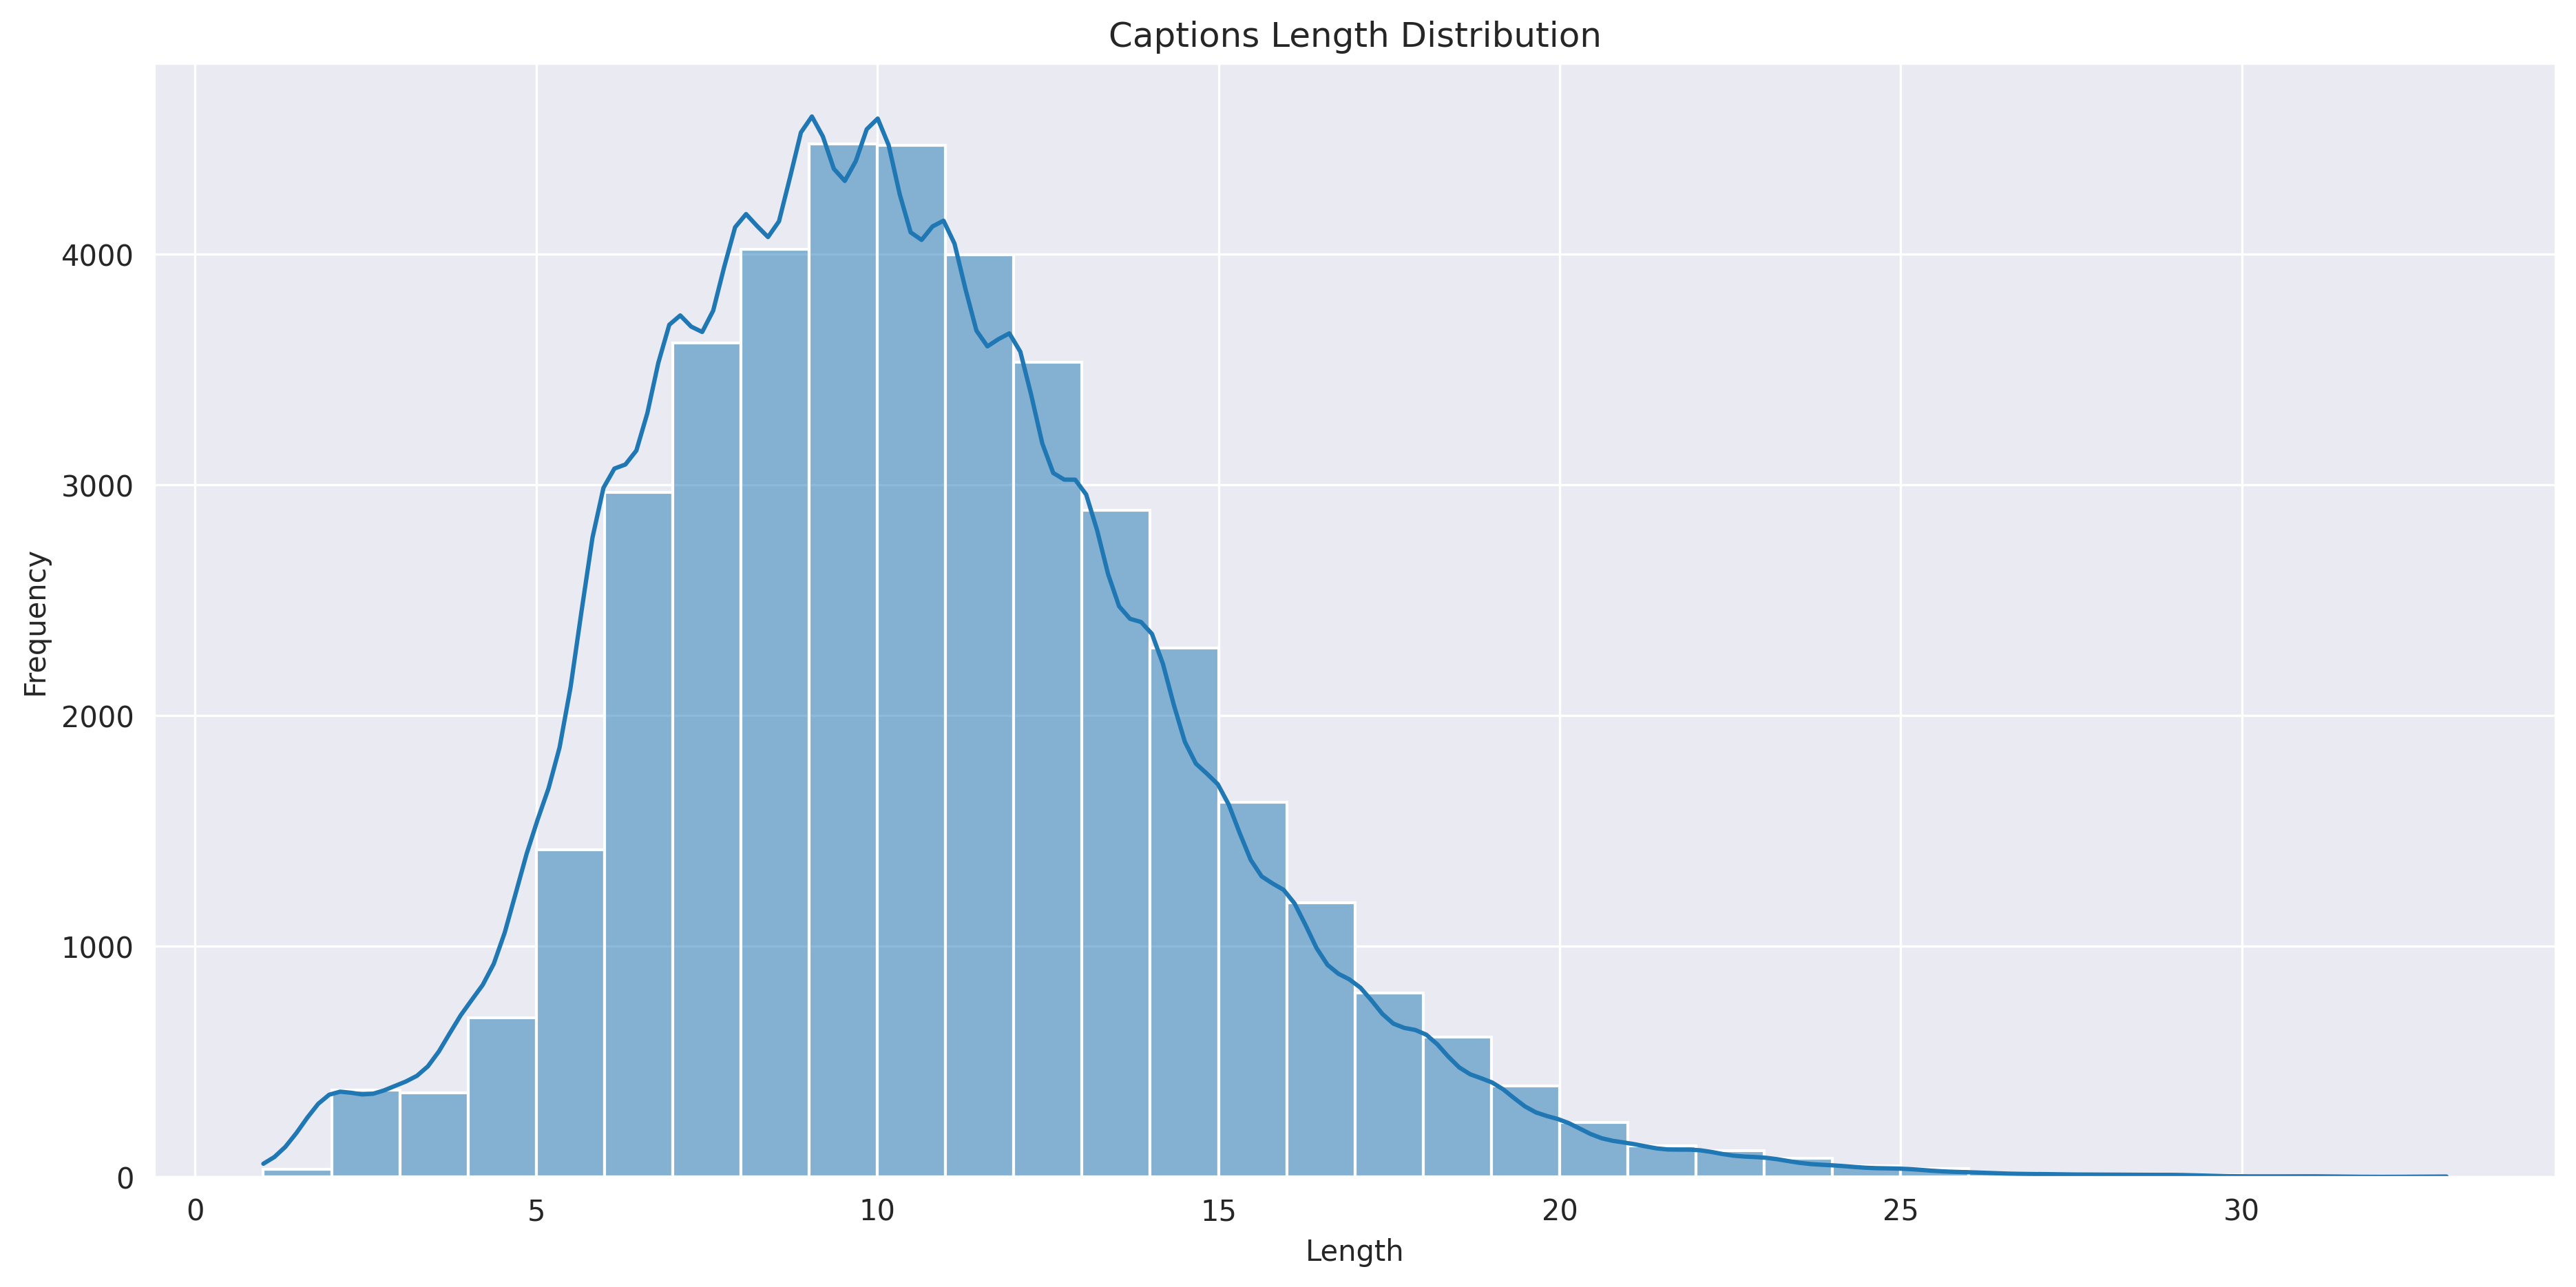

In [40]:
def tokenize_captions(captions):
    tokenizer = Tokenizer(oov_token="<unk>")
    tokenizer.fit_on_texts(cleaned_captions)
    return tokenizer

tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split()) for x in data], kde=True, binwidth=1)
    plt.title('Captions Length Distribution')
    plt.xlabel('Length'); plt.ylabel('Frequency')
    plt.show()

captions_length(cleaned_captions)


In [41]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    if image_id in train_image_ids:
        train_captions.append(caption)
    elif image_id in val_image_ids:
        val_captions.append(caption)
    elif image_id in test_image_ids:
        test_captions.append(caption)


In [42]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights='imagenet')
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

train_image_features, val_image_features, test_image_features = {}, {}, {}
pbar = tqdm(total=len(all_image_ids), desc="Extracting Features")

for image_id in all_image_ids:
    image_path = os.path.join(images_directory, image_id)
    features = extract_image_features(inception_v3_model, image_path).flatten()

    if image_id in train_image_ids:
        train_image_features[image_id] = features
    elif image_id in val_image_ids:
        val_image_features[image_id] = features
    elif image_id in test_image_ids:
        test_image_features[image_id] = features

    pbar.update(1)

pbar.close()


Extracting Features: 100%|██████████| 2000/2000 [14:07<00:00,  2.36it/s]


In [43]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    while True:
        np.random.shuffle(captions)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start:end]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.strip()
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            yield (np.array(X_images), np.array(X_captions)), np.array(y)


In [44]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,))
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs)
    return model


In [45]:
batch_size_train = 270
batch_size_val = 150

cnn_output_dim = 2048
max_caption_length = max(len(x.split()) for x in cleaned_captions) + 1

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
def lr_scheduler(epoch, lr): return float(lr * tf.math.exp(-0.6))
lr_schedule = LearningRateScheduler(lr_scheduler)

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

history = caption_model.fit(
    train_data_generator,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_data_generator,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 314s 10s/step - loss: 6.1590 - val_loss: 5.3377 - learning_rate: 0.0055
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - loss: 4.0262 - val_loss: 4.3886 - learning_rate: 0.0030
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - loss: 3.3774 - val_loss: 3.9928 - learning_rate: 0.0017
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 292s 9s/step - loss: 3.0536 - val_loss: 3.8877 - learning_rate: 9.0718e-04
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - loss: 2.8730 - val_loss: 3.8442 - learning_rate: 4.9787e-04
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 322s 10s/step - loss: 2.7458 - val_loss: 3.8462 - learning_rate: 2.7324e-04
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - loss: 2.7119 - val_loss: 3.8234 - learning_rate: 1.4996e-04
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 324s 11s/step - loss: 2.6767 - val_loss: 3.7850 - learning_rate: 8.2297e-05
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - loss: 2.6617 - val_loss: 3.7865 - learning_rate: 

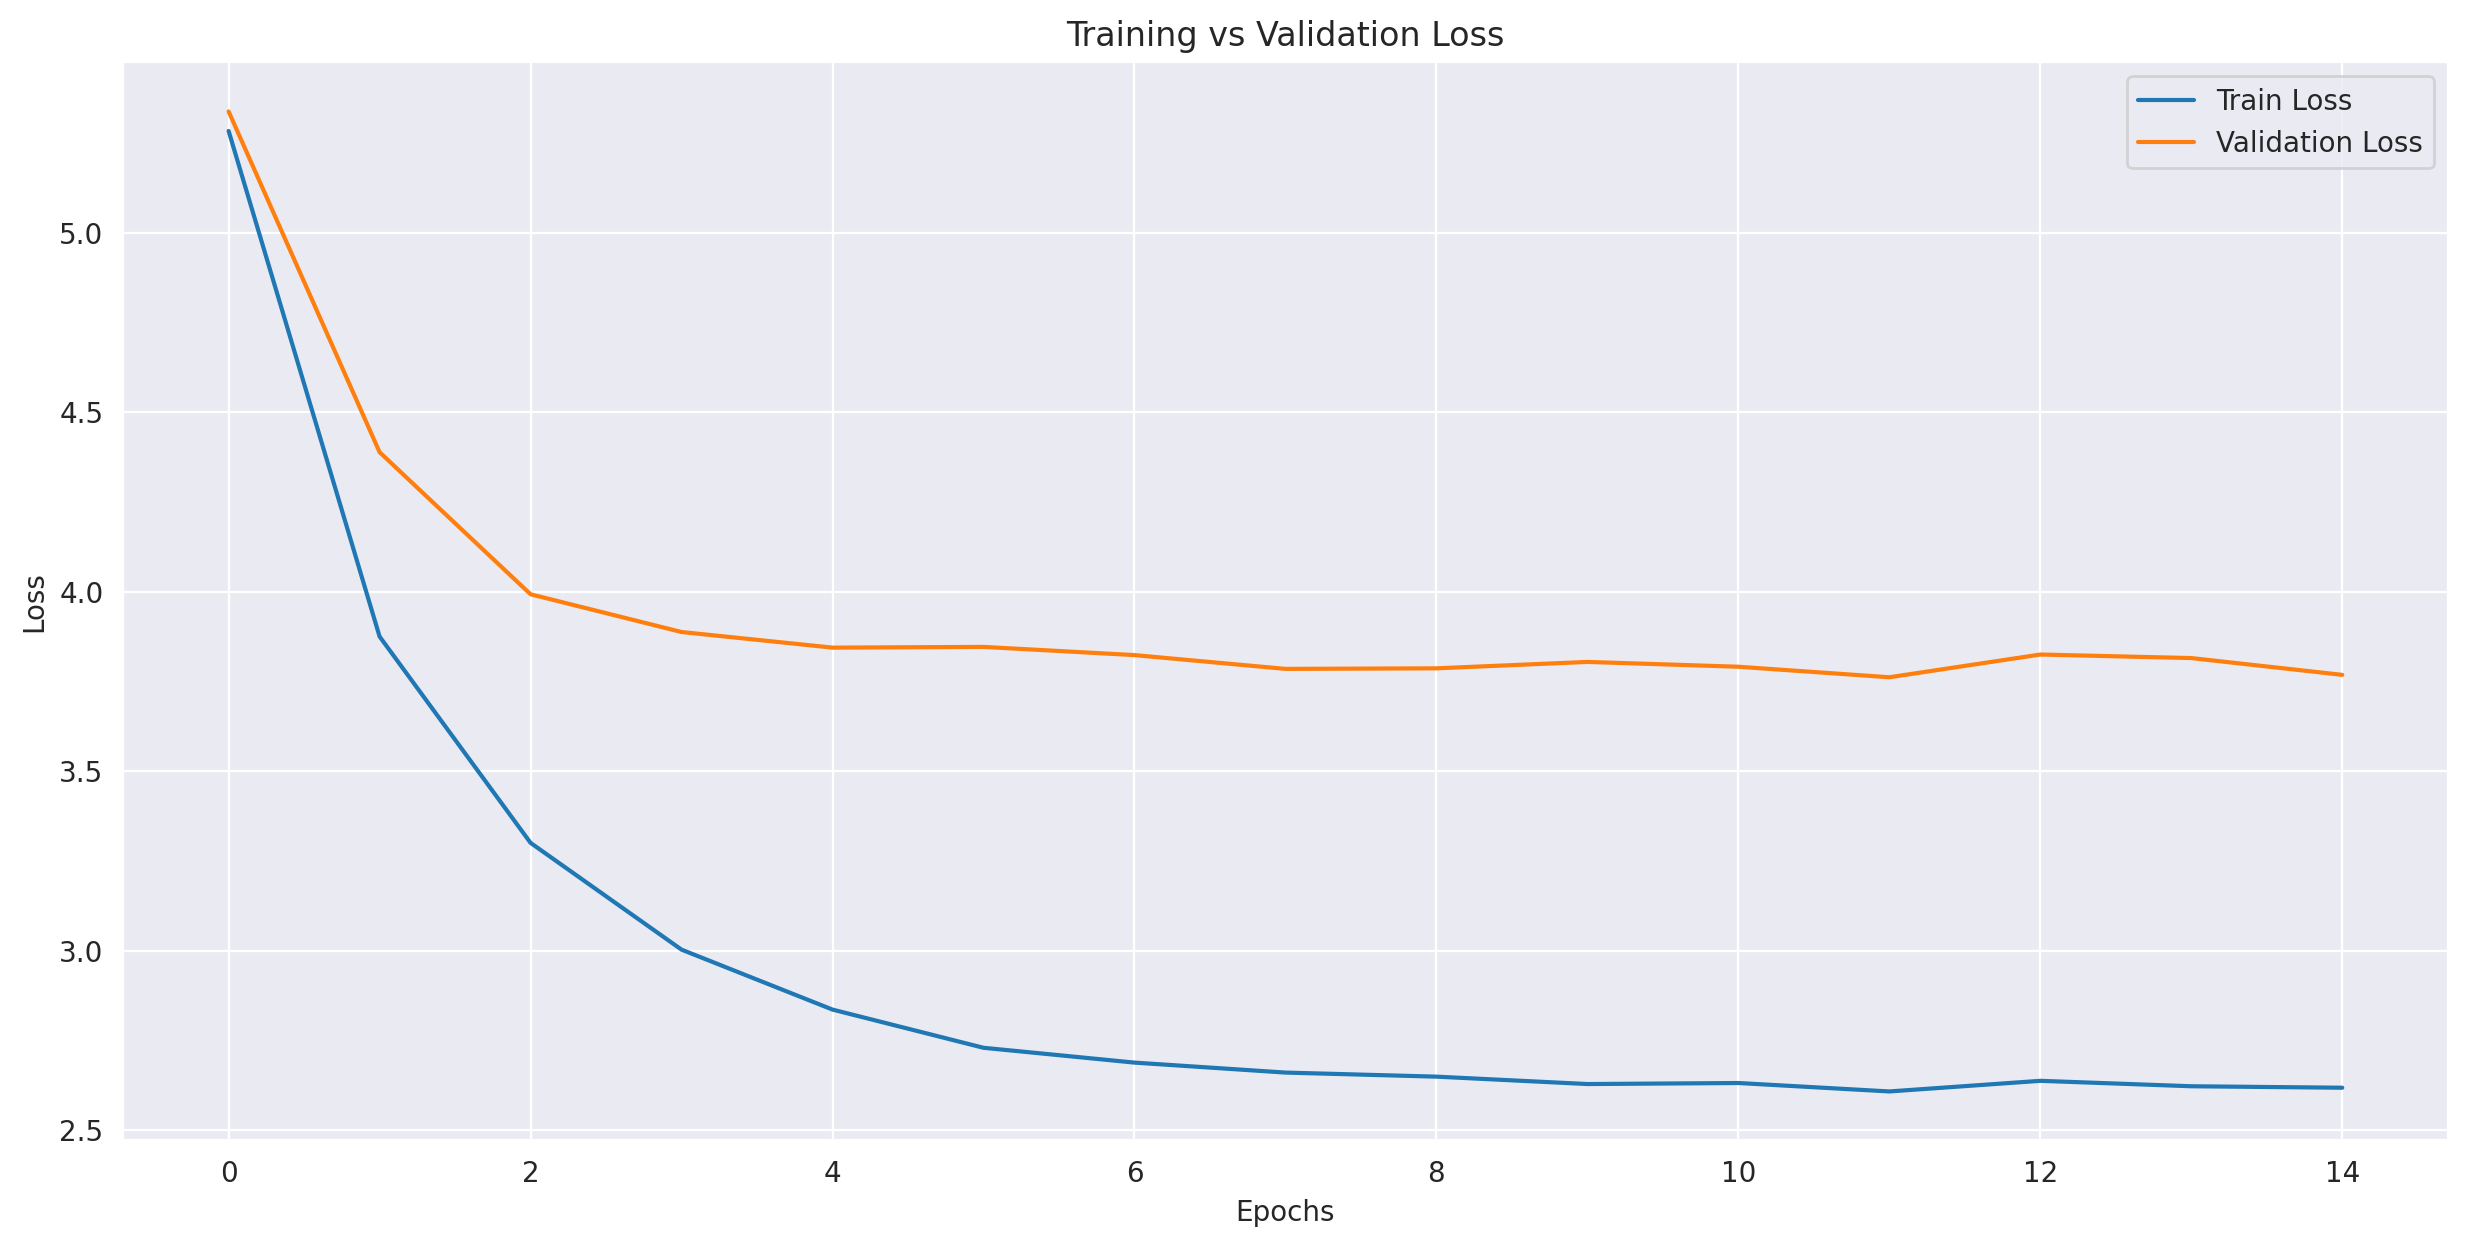

In [46]:
plt.figure(figsize=(15, 7), dpi=200)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()


In [48]:
def greedy_generator(image_features):
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        pred = caption_model.predict([image_features.reshape(1, -1), sequence], verbose=0)
        word = tokenizer.index_word[np.argmax(pred)]
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text.replace('start ', '').replace(' end', '')


In [49]:
def beam_search_generator(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length)
            preds = caption_model.predict([image_features.reshape(1, -1), sequence], verbose=0)[0]
            word_preds = np.argsort(preds)[-K_beams:]
            for w in word_preds:
                next_seq, prob = s[0][:], s[1]
                next_seq.append(w)
                prob += np.log(preds[w]) if log else preds[w]
                temp.append([next_seq, prob])
        start_word = sorted(temp, key=lambda x: x[1])[-K_beams:]

    final_caption = [tokenizer.index_word[i] for i in start_word[-1][0]]
    caption_words = []
    for word in final_caption:
        if word != 'end':
            caption_words.append(word)
        else:
            break
    return ' '.join(caption_words[1:])


In [50]:
def BLEU_score(actual, greedy, beam_search):
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        f'BLEU-1 Greedy: {round(score_greedy_1, 5)}',
        f'BLEU-2 Greedy: {round(score_greedy_2, 5)}',
        f'Greedy: {greedy[0]}',
        f'BLEU-1 Beam Search: {round(score_BS_1, 5)}',
        f'BLEU-2 Beam Search: {round(score_BS_2, 5)}',
        f'Beam Search: {beam_search[0]}'
    ]


In [51]:
generated_captions = {}
pbar = tqdm(total=len(test_image_features), desc="Generating Greedy Captions")

for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()


Generating Greedy Captions: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it]


In [52]:
test_actual_captions = {}
for caption in test_captions:
    image_id, text = caption.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(text.strip())


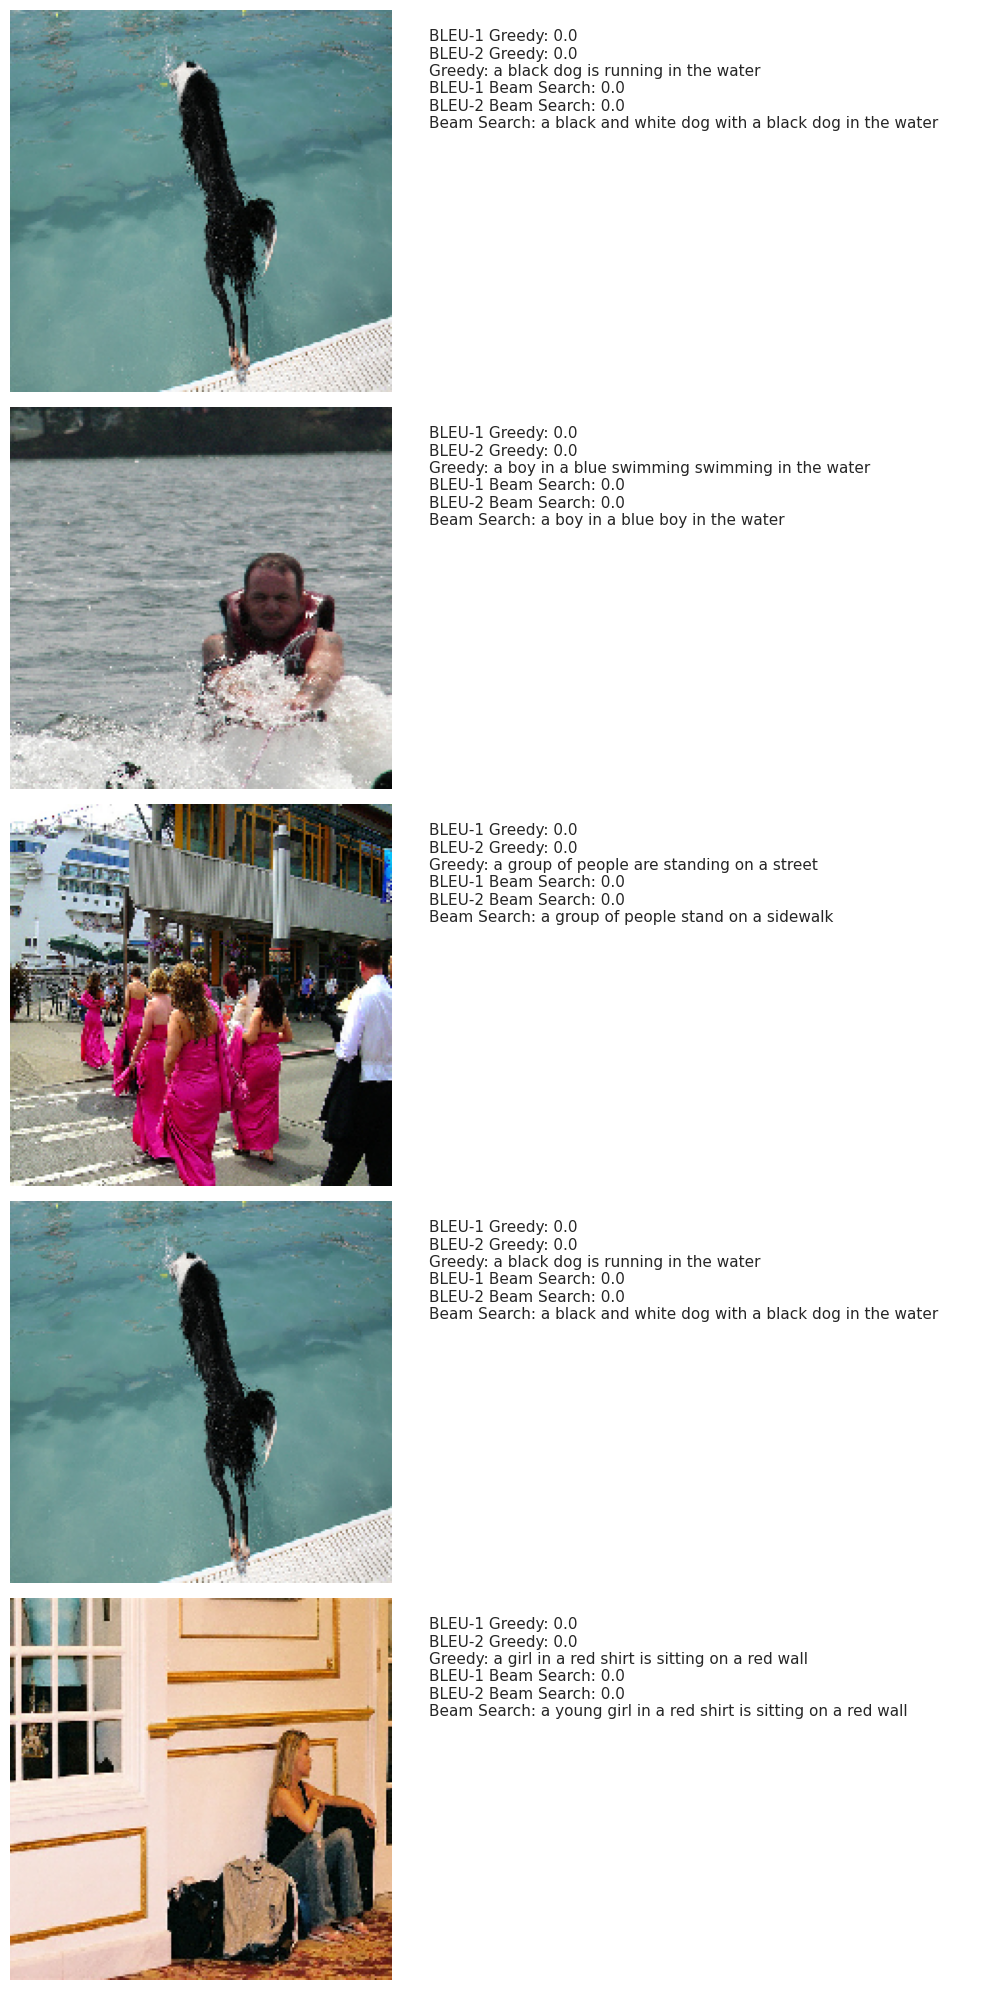

In [53]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys())
    images = [np.random.choice(keys) for _ in range(num_of_images)]

    fig = plt.figure(figsize=(12, 4 * num_of_images))
    count = 1

    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "").replace(" end", "") for x in actual_cap]

        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        caps_with_score = evaluator(actual_cap, [greedy_cap]*len(actual_cap), [beamS_cap]*len(actual_cap))

        # --- Image ---
        ax1 = fig.add_subplot(num_of_images, 2, count)
        image_load = load_img(images_directory + filename, target_size=(199, 199, 3))
        ax1.imshow(image_load)
        ax1.axis('off')
        count += 1

        # --- Captions + Scores ---
        ax2 = fig.add_subplot(num_of_images, 2, count)
        ax2.axis('off')
        text_block = "\n".join(caps_with_score)
        ax2.text(0.01, 0.95, text_block, fontsize=11, va='top')
        count += 1

    plt.tight_layout()
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 5)
